In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import duckdb
import seaborn as sns
font_scale = 7
sns.set_theme(style='ticks', font_scale=font_scale, palette=sns.color_palette('Set2'),)
import sqlalchemy as sa
import seaborn as sns
import polars as pl
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from conf import conf
from dafm import plots

In [3]:
duckdb.sql("""
attach '../runs.sqlite';
use runs;
""")

In [4]:
engine = conf.get_engine()
session = conf.sa.orm.Session(engine)
session.begin()

# Run queries

### Datasets

In [5]:
dataset_cols = ''.join(map(str.strip, """
    id,
    dataset_name,
    dataset_name_latex_short,
    time_step_count,
    time_step_count_drop_first,
    observe_every_n_time_steps,
""".splitlines()))

In [6]:
dataset_rows = duckdb.sql(f"""
    select {dataset_cols} from paper_lorenz96
    union
    select {dataset_cols} from paper_kuramoto_sivashinsky
--  union
--  select {dataset_cols} from paper_navier_stokes_dim_64
    union
    select {dataset_cols} from paper_navier_stokes_dim_256
""")
dataset_multiple = 3
assert len(dataset_rows) == dataset_multiple

### Models

In [7]:
model_cols = ''.join(map(str.strip, """
    id,
    model_name,
    sampling_time_step_count,
    hyperparameter1,
    hyperparameter1_name,
    hyperparameter2,
    hyperparameter2_name,
""".splitlines()))

In [8]:
topk_hyperparameters = duckdb.sql("""
    select
        *
    from read_csv('../sweeps/topk_hyperparameters.csv')
    where k = 1
""")

In [9]:
model_rows = duckdb.sql(rf"""
    select {model_cols} from ensf
    union
    select {model_cols} from enff_ot
    union
    select {model_cols} from enff_f2p
""")
model_multiple = 3
assert duckdb.sql('select count(distinct model_name) from model_rows').fetchall()[0][0] == model_multiple

### General

In [10]:
rows = duckdb.sql("""
    select alt_id, rng_seed, dataset_rows.*, model_rows.*
    from Conf
    join dataset_rows on Conf.Dataset = dataset_rows.id
    join model_rows on Conf.Model = model_rows.id
    join topk_hyperparameters on (
        dataset_rows.dataset_name = topk_hyperparameters.dataset_name
        and
        model_rows.model_name = topk_hyperparameters.model_name
        and
        model_rows.sampling_time_step_count = topk_hyperparameters.sampling_time_step_count
        and
        (model_rows.hyperparameter1, model_rows.hyperparameter2) == (topk_hyperparameters.hyperparameter1, topk_hyperparameters.hyperparameter2)
    )
    where true
    and rng_seed in (select * from rng_seed_test)
    and model_rows.sampling_time_step_count in (select * from sweep_sampling_time_step_count)
""")
rng_seed_multiple = duckdb.sql("select count(*) from rng_seed_test").fetchall()[0][0]
sampling_time_step_count_multiple = duckdb.sql('select count(*) from sweep_sampling_time_step_count').fetchall()[0][0]
multiple = (
    dataset_multiple
    * rng_seed_multiple
    * model_multiple
    * sampling_time_step_count_multiple
    - 5  # EnSF hyperparameter tuning fails for NavierStokesDim256 when T = 5
)
assert len(rows) == multiple, f'{len(rows) = } != {multiple}'

In [11]:
duckdb.sql("""
    select
        dataset_name,
        model_name,
        sampling_time_step_count,
        count(*) as num_rows,
    from rows
    where
        model_name = 'EnSF'
        and dataset_name = 'NavierStokesDim256'
    group by
        dataset_name,
        model_name,
        sampling_time_step_count,
    order by dataset_name, model_name desc, sampling_time_step_count
""")

┌────────────────────┬────────────┬──────────────────────────┬──────────┐
│    dataset_name    │ model_name │ sampling_time_step_count │ num_rows │
│      varchar       │  varchar   │          int64           │  int64   │
├────────────────────┼────────────┼──────────────────────────┼──────────┤
│ NavierStokesDim256 │ EnSF       │                       10 │        5 │
│ NavierStokesDim256 │ EnSF       │                       20 │        5 │
│ NavierStokesDim256 │ EnSF       │                       50 │        5 │
│ NavierStokesDim256 │ EnSF       │                      100 │        5 │
└────────────────────┴────────────┴──────────────────────────┴──────────┘

In [12]:
logged_metrics_file_paths = plots.get_logged_metrics_file_paths(rows)
duckdb.sql("""
set variable dataset_metrics_filepaths = (
    select list(path) from logged_metrics_file_paths where exists
)
""")

In [13]:
observation_steps_back = 50
logged_metrics = duckdb.sql(f"""
    select rows.*, logs.*,
    from (
        select split(filename, '/')[-2] as alt_id, step, time_s, crps, rmse,
        from read_csv(getvariable(dataset_metrics_filepaths), filename=true, union_by_name=true)
    ) as logs
    join rows on rows.alt_id = logs.alt_id
    where true
    and (logs.step - time_step_count_drop_first - 1) % observe_every_n_time_steps == 0 -- include only analysis time steps
    and step > time_step_count - observe_every_n_time_steps * {observation_steps_back}
""").pl()
logged_metrics

alt_id,rng_seed,id,dataset_name,dataset_name_latex_short,time_step_count,time_step_count_drop_first,observe_every_n_time_steps,id_1,model_name,sampling_time_step_count,hyperparameter1,hyperparameter1_name,hyperparameter2,hyperparameter2_name,alt_id_1,step,time_s,crps,rmse
str,i64,i64,str,str,i64,i64,i64,i64,str,i64,f64,str,f64,str,str,i64,f64,f64,f64
"""y1c79r6k""",462133975,85,"""NavierStokesDim256""","""NS ($256 \times 256$)""",6000,0,100,862,"""EnFF-F2P""",50,0.001,"""sigma_min""",0.001,"""lambda""","""y1c79r6k""",1001,0.711959,11.494024,0.029046
"""y1c79r6k""",462133975,85,"""NavierStokesDim256""","""NS ($256 \times 256$)""",6000,0,100,862,"""EnFF-F2P""",50,0.001,"""sigma_min""",0.001,"""lambda""","""y1c79r6k""",1101,0.746451,11.144363,0.029589
"""y1c79r6k""",462133975,85,"""NavierStokesDim256""","""NS ($256 \times 256$)""",6000,0,100,862,"""EnFF-F2P""",50,0.001,"""sigma_min""",0.001,"""lambda""","""y1c79r6k""",1201,0.733012,10.556831,0.028488
"""y1c79r6k""",462133975,85,"""NavierStokesDim256""","""NS ($256 \times 256$)""",6000,0,100,862,"""EnFF-F2P""",50,0.001,"""sigma_min""",0.001,"""lambda""","""y1c79r6k""",1301,0.714879,10.029485,0.027432
"""y1c79r6k""",462133975,85,"""NavierStokesDim256""","""NS ($256 \times 256$)""",6000,0,100,862,"""EnFF-F2P""",50,0.001,"""sigma_min""",0.001,"""lambda""","""y1c79r6k""",1401,0.734622,9.36872,0.025552
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""raz4zehi""",19704671,85,"""NavierStokesDim256""","""NS ($256 \times 256$)""",6000,0,100,923,"""EnFF-OT""",20,0.00001,"""sigma_min""",0.05,"""lambda""","""raz4zehi""",5501,0.332448,11.292249,0.025473
"""raz4zehi""",19704671,85,"""NavierStokesDim256""","""NS ($256 \times 256$)""",6000,0,100,923,"""EnFF-OT""",20,0.00001,"""sigma_min""",0.05,"""lambda""","""raz4zehi""",5601,0.324889,12.411811,0.027997
"""raz4zehi""",19704671,85,"""NavierStokesDim256""","""NS ($256 \times 256$)""",6000,0,100,923,"""EnFF-OT""",20,0.00001,"""sigma_min""",0.05,"""lambda""","""raz4zehi""",5701,0.440909,11.657002,0.026295


In [14]:
required_observation_step_count = duckdb.sql(f"""
    select
        dataset_name,
        max(observation_step_count) as required_observation_step_count,
    from (
        select
            dataset_name,
            count(*) as observation_step_count,
        from logged_metrics
        group by alt_id, dataset_name
    )
    group by dataset_name
""")
required_observation_step_count

┌─────────────────────┬─────────────────────────────────┐
│    dataset_name     │ required_observation_step_count │
│       varchar       │              int64              │
├─────────────────────┼─────────────────────────────────┤
│ KuramotoSivashinsky │                              50 │
│ Lorenz96Bao2024EnSF │                              50 │
│ NavierStokesDim256  │                              50 │
└─────────────────────┴─────────────────────────────────┘

In [15]:
failed_before_finish_cols = """
    alt_id,
    dataset_name,
    model_name,
"""
failed_before_finish = duckdb.sql(f"""
    select
        observation_steps_back.*,
    from (
        select
            {failed_before_finish_cols}
            count(*) as observation_step_count,
        from logged_metrics
        group by {failed_before_finish_cols}
    ) as observation_steps_back
    join required_observation_step_count
    on observation_steps_back.dataset_name = required_observation_step_count.dataset_name
    and observation_steps_back.observation_step_count < required_observation_step_count.required_observation_step_count
    order by observation_steps_back.dataset_name, model_name desc, observation_step_count
""")
failed_before_finish

┌─────────┬──────────────┬────────────┬────────────────────────┐
│ alt_id  │ dataset_name │ model_name │ observation_step_count │
│ varchar │   varchar    │  varchar   │         int64          │
├─────────┴──────────────┴────────────┴────────────────────────┤
│                            0 rows                            │
└──────────────────────────────────────────────────────────────┘

In [16]:
logged_metrics = duckdb.sql("""
    select
        *
    from logged_metrics
    where alt_id not in (select alt_id from failed_before_finish)
""")

In [17]:
duckdb.sql("""
    select
        alt_id,
        dataset_name,
        model_name,
        sampling_time_step_count,
    from rows
    where alt_id not in (select alt_id from logged_metrics)
    order by dataset_name, model_name, sampling_time_step_count
""")

┌─────────┬──────────────┬────────────┬──────────────────────────┐
│ alt_id  │ dataset_name │ model_name │ sampling_time_step_count │
│ varchar │   varchar    │  varchar   │          int64           │
├─────────┴──────────────┴────────────┴──────────────────────────┤
│                             0 rows                             │
└────────────────────────────────────────────────────────────────┘

In [18]:
group_by = """
    alt_id,
    rng_seed,
    dataset_name,
    dataset_name_latex_short,
    model_name,
    sampling_time_step_count,
    hyperparameter1,
    hyperparameter1_name,
    hyperparameter2,
    hyperparameter2_name,
"""
logged_metrics_means = duckdb.sql(f"""
    select
        {group_by}
        mean(time_s) as time_s_mean,
        mean(rmse) as rmse,
        mean(crps) as crps,
    from logged_metrics
    group by
        {group_by}
""")
logged_metrics_means.show(max_width=125)

┌──────────┬───────────┬─────────────────────┬───┬──────────────────────┬──────────────────────┬────────────────────┐
│  alt_id  │ rng_seed  │    dataset_name     │ … │     time_s_mean      │         rmse         │        crps        │
│ varchar  │   int64   │       varchar       │   │        double        │        double        │       double       │
├──────────┼───────────┼─────────────────────┼───┼──────────────────────┼──────────────────────┼────────────────────┤
│ 0w9npe1a │ 462133975 │ KuramotoSivashinsky │ … │  0.10086342694000053 │  0.11863295552810856 │ 3.2130486054983236 │
│ 4wzpphxh │ 462133975 │ KuramotoSivashinsky │ … │  0.03615923010000046 │  0.05375283100472597 │ 1.5689821007598723 │
│ wkarpzca │  97616566 │ Lorenz96Bao2024EnSF │ … │    4.954130366440008 │  0.17200839012861252 │ 161.12862396240234 │
│ lv4cgxgj │ 462133975 │ Lorenz96Bao2024EnSF │ … │    0.699642483780002 │  0.35299828708171843 │  296.5081396484375 │
│ l14v9i31 │  19704671 │ KuramotoSivashinsky │ … │ 0.018

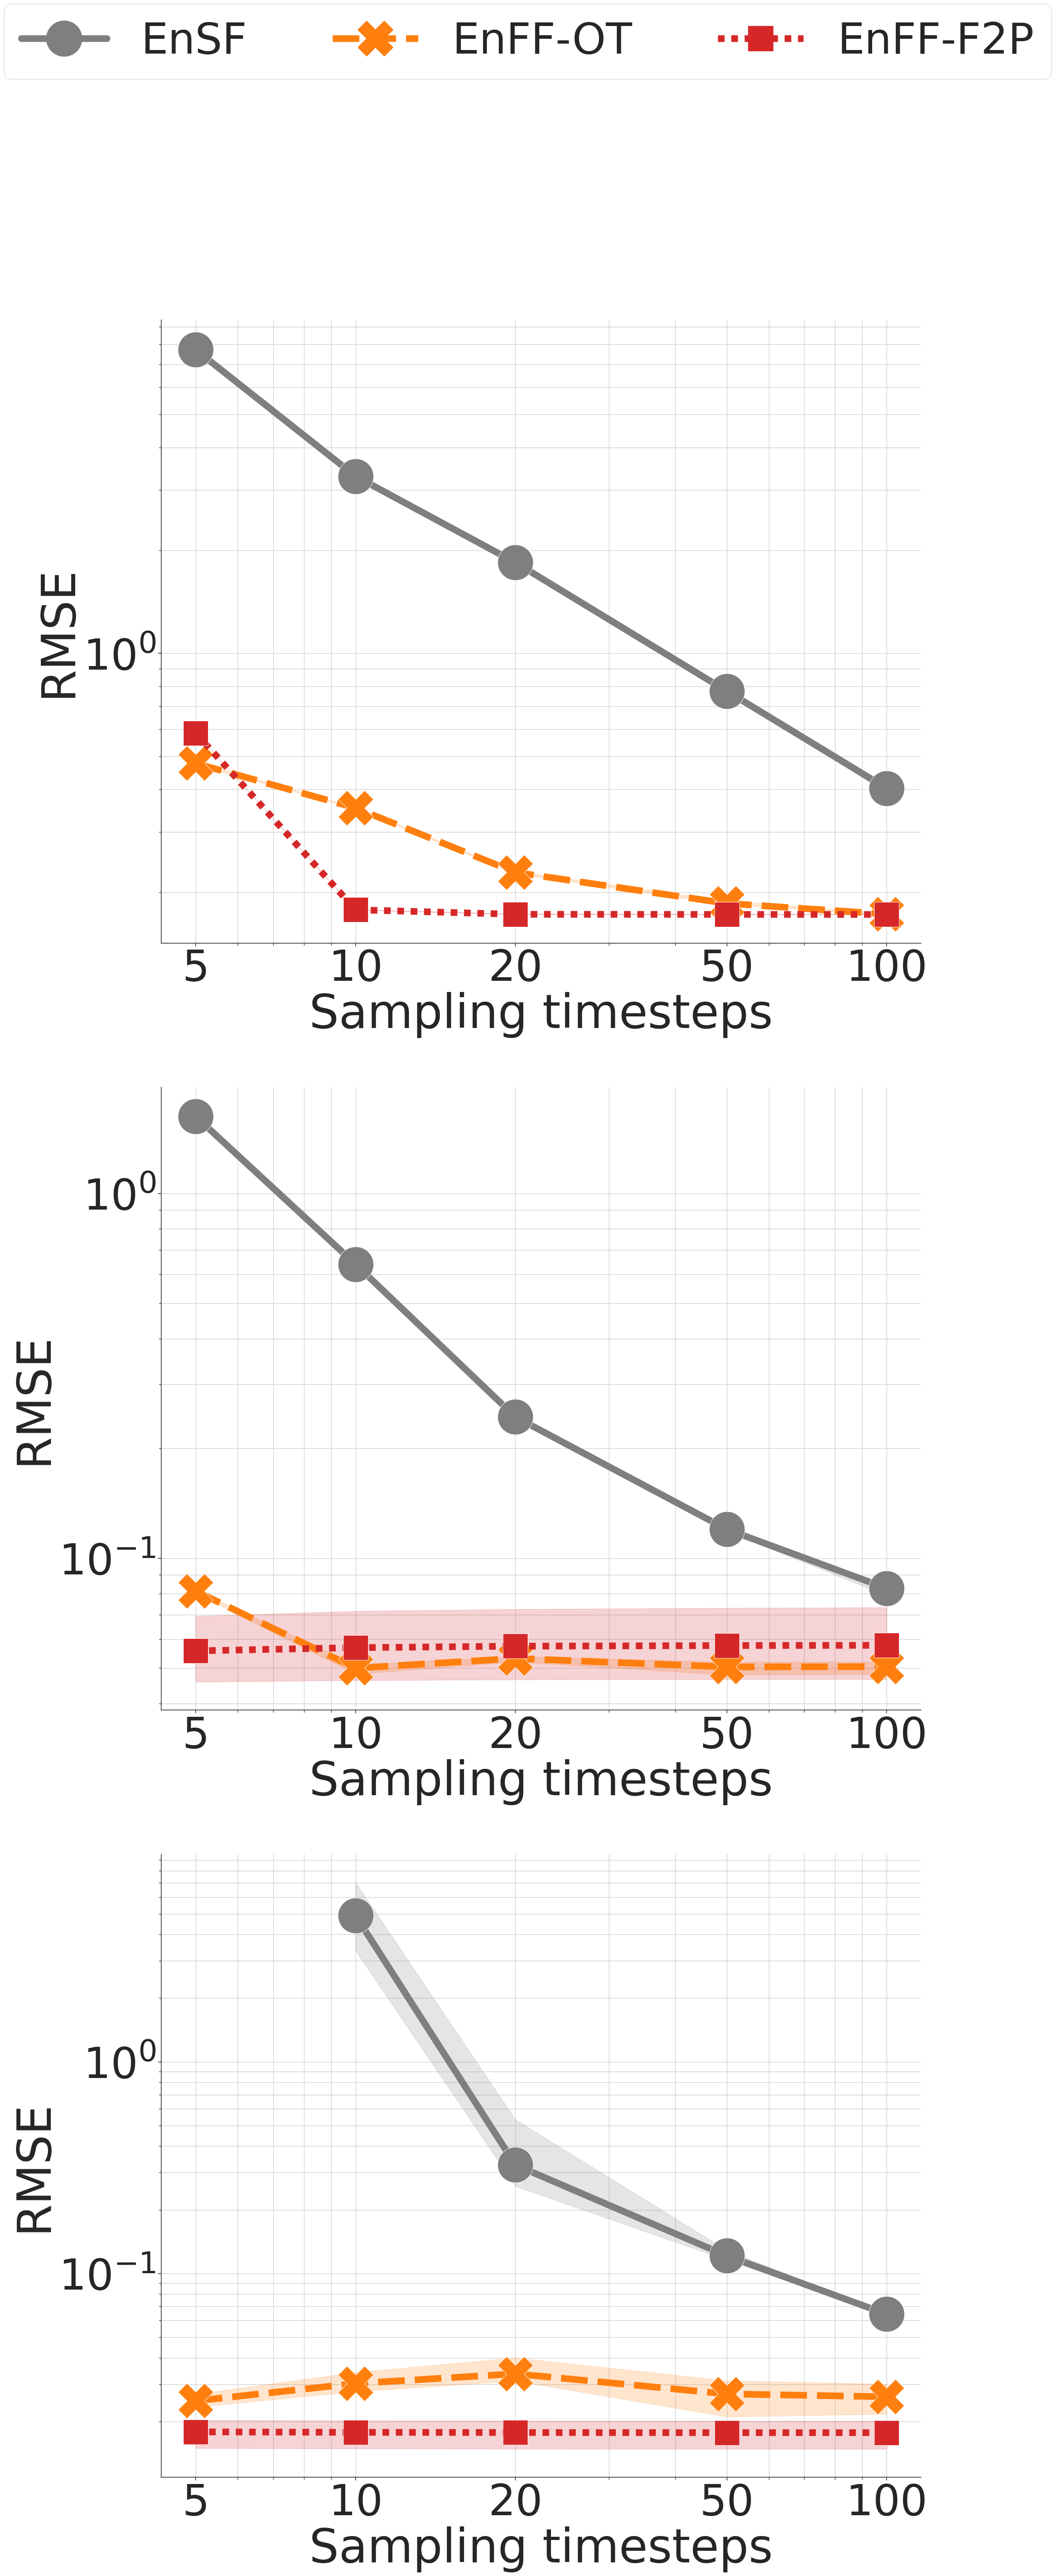

In [19]:
plot_data = logged_metrics_means.pl()
hue_order = sorted(plot_data['model_name'].unique(), key=plots.MODEL_ORDER.get)
xticks = plot_data['sampling_time_step_count'].unique().to_numpy()
xticklabels = xticks
y = 'rmse'
plot_metric = (
    sns.relplot(
        kind='line',
        estimator='mean',
        errorbar=('pi', 100),
        data=plot_data,
        x='sampling_time_step_count',
        y=y,
        row='dataset_name',
        hue='model_name',
        hue_order=hue_order,
        style='model_name',
        style_order=hue_order,
        palette=plots.MODEL_PALETTE,
        markers=True,
        markersize=64,
        linewidth=12,
        height=20,
        aspect=1.3,
        facet_kws=dict(
            sharex=False,
            sharey=False,
        ),
    )
    .set(
        xscale='log',
        yscale='log',
        title='',
        xticks=xticks,
        xticklabels=xticklabels,
        xlabel='Sampling timesteps',
        ylabel=y.upper(),
    )
)
sns.move_legend(
    plot_metric,
    loc='upper center',
    ncol=len(hue_order),
    title='',
    bbox_to_anchor=(.455, 1.10),
    frameon=True,
    fancybox=True,
)
for (row, col, hue), _ in plot_metric.facet_data():
    ax = plot_metric.axes[row, col]
    ax.grid()
    ax.grid(which='minor')

In [20]:
plots.save_all_subfigures(plot_metric, y.upper())